In [12]:
!pip install --quiet pycountry

# Customer Information

# Data Loading

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
import pycountry
from transformers import pipeline
from tqdm.auto import tqdm
import torch

%matplotlib inline

In [18]:
# 데이터 불러오기
df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./submission.csv')

In [19]:
col = [
    'customer_country', #고객의 국적
    'customer_idx', #고객의 회사명
    'customer_type', #고객 유형
    'customer_job', #고객의 직업군
    'customer_position', #고객의 회사 직책
    'enterprise', #Global 기업인지, Small/Medium 규모의 기업인지
    'is_converted',
]

In [20]:
df_train = df_train[col]
df_test = df_test[col]

In [12]:
# True로 예측된 개수
num_true = sum(df_train['is_converted'] == 1)
print(f'Number of Total Train length: {len(df_train)}')
print(f"Number of True: {num_true}")
print(f'Number of Total Test length: {len(df_test)}')

Number of Total Train length: 59299
Number of True: 4850
Number of Total Test length: 5271


# customer_country

In [45]:
def find_country(text):
    # 모든 국가를 순회하며 이름이 문자열 내에 있는지 확인
    for country in pycountry.countries:
        if country.name in text:
            return country.name
        if hasattr(country, 'common_name') and country.common_name in text:
            return country.common_name
        if hasattr(country, 'official_name') and country.official_name in text:
            return country.official_name
    return None

In [46]:
def standardize_address(address):
    if isinstance(address, str):
        # 주소를 '/' 기준으로 분리하고 앞뒤 공백 제거
        parts = address.strip('/').split('/')
        parts = [part.strip() for part in parts]
        
        # 전체 문자열에서 국가 이름 추출 시도
        country = find_country(address)
        if country:
            return country.title()  # 국가 이름을 제목 형식으로 변환
    return None

In [ ]:
# 함수 적용
df_train['customer_country'] = df_train['customer_country'].apply(standardize_address)
df_test['customer_country'] = df_test['customer_country'].apply(standardize_address)

/home/baekkwsl/anaconda3/envs/py11/lib/python3.11/site-packages/pycountry/db.py:51: UserWarning: Country's common_name not found. Country name provided instead.
  warnings.warn(warning_message, UserWarning)
/home/baekkwsl/anaconda3/envs/py11/lib/python3.11/site-packages/pycountry/db.py:51: UserWarning: Country's official_name not found. Country name provided instead.
  warnings.warn(warning_message, UserWarning)


# customer_idx

In [24]:
df_train['customer_idx'] = df_train['customer_idx'].astype(str)
df_test['customer_idx'] = df_test['customer_idx'].astype(str)

In [17]:
def plot_conversion_rate_by_column(df, column_name, top_n=None):
    # column_name 별로 is_converted의 True와 False의 개수를 집계합니다.
    conversion_counts = df.groupby(column_name)['is_converted'].value_counts().unstack(fill_value=0)
    # True 값의 비율을 계산합니다.
    conversion_rate = conversion_counts[True] / conversion_counts.sum(axis=1)
    
    # 비율을 DataFrame으로 만듭니다.
    conversion_rate_df = conversion_rate.sort_values(ascending=False).reset_index(name='Conversion Rate')
    
    # top_n이 지정된 경우, 상위 top_n개의 카테고리만 선택합니다.
    if top_n is not None:
        conversion_rate_df = conversion_rate_df.head(top_n)
    
    # Seaborn의 barplot을 사용하여 수직 막대 그래프를 그립니다.
    plt.figure(figsize=(10, 30), dpi=300)
    sns.barplot(data=conversion_rate_df, y=column_name, x='Conversion Rate', palette="viridis")
    
    # 그래프의 타이틀과 레이블을 설정합니다.
    plt.title(f'Conversion Rate by {column_name}')
    plt.xlabel('Conversion Rate')
    plt.ylabel(column_name)
    
    # 그래프를 보여줍니다.
    plt.show()

In [18]:
print(df_train['customer_country'].unique())
print(len(df_train['customer_country'].unique()))

['Philippines' 'India' 'Niger' 'Saudi Arabia' 'Benin' 'Singapore' 'Brazil'
 None 'South Africa' 'United States' 'Colombia' 'Mexico' 'Ghana' 'Egypt'
 'Congo' 'Ethiopia' 'Australia' 'Kenya' 'Indonesia' 'Oman' 'Pakistan'
 'United Kingdom' 'Guatemala' 'Panama' 'Canada' 'Bangladesh' 'Guinea'
 'Tanzania' 'Qatar' 'Afghanistan' 'Chile' 'Mozambique' 'Türkiye'
 'El Salvador' 'Togo' 'Jordan' 'Iraq' 'Israel' 'Sri Lanka' 'South Korea'
 'Portugal' 'Mauritania' 'Uruguay' 'Peru' 'Germany' 'Romania' 'Norway'
 'Jamaica' 'Hungary' 'Poland' 'Spain' 'Argentina' 'Ecuador' 'Senegal'
 'Hong Kong' 'Malaysia' 'Japan' 'Kuwait' 'Ireland' 'Albania' 'Greece'
 'Algeria' 'Nicaragua' 'Slovenia' 'Italy' 'Netherlands' 'Dominica'
 'France' 'Uganda' 'Iran' 'Paraguay' 'Bolivia' 'Namibia' 'Tunisia'
 'Puerto Rico' 'Anguilla' 'Croatia' 'Fiji' 'Denmark' 'Sweden' 'Cyprus'
 'Belgium' 'Venezuela' 'Maldives' 'Morocco' 'Switzerland' 'Honduras'
 'Austria' 'Burkina Faso' 'Thailand' 'Bahamas' 'Jersey' 'Cambodia'
 'Zimbabwe' 'Vietnam' 

# customer_type

In [27]:
print(df_train['customer_type'].unique())
print(df_test['customer_type'].unique())

['End-Customer' 'Specifier/ Influencer' 'Service Partner'
 'Channel Partner' nan 'Corporate' 'End Customer' 'Specifier / Influencer'
 'Solution Eco-Partner' 'Distributor' 'Other' 'System Integrator'
 'Consultant' 'Installer' 'Homeowner' 'Others' 'Technician'
 'Installer/Contractor' 'Engineer' 'Manager / Director' 'Developer' 'Etc.'
 'Architect/Consultant' 'End-user' 'HVAC Engineer' 'Reseller'
 'Software/Solution Provider' 'Software / Solution Provider'
 'Dealer/Distributor' 'Technical Assistant' 'Commercial end-user'
 'Interior Designer' 'Home Owner' 'Administrator']
['End Customer' 'Specifier/ Influencer' nan 'Service Partner'
 'Channel Partner' 'Solution Eco-Partner' 'Developer' 'End-Customer']


In [28]:
intent_categories = [
    'End Customer',  # 최종 고객
    'Specifier / Influencer',  # 사양 정의자 / 영향력자
    'Service Partner',  # 서비스 파트너
    'Channel Partner',  # 채널 파트너
    'Corporate',  # 기업
    'Solution Eco-Partner',  # 솔루션 에코 파트너
    'Distributor',  # 유통업체
    'System Integrator',  # 시스템 통합업체
    'Consultant',  # 컨설턴트
    'Installer / Contractor',  # 설치업체 / 계약업체
    'Technician',  # 기술자
    'Manager / Director',  # 관리자 / 이사
    'Developer',  # 개발자
    'Architect / Consultant',  # 건축가 / 컨설턴트
    'Reseller',  # 재판매업체
    'Software / Solution Provider',  # 소프트웨어 / 솔루션 제공업체
    'Dealer / Distributor',  # 딜러 / 유통업체
    'Technical Assistant',  # 기술 지원 직원
    'Commercial End-User',  # 상업용 최종 사용자
    'Interior Designer',  # 인테리어 디자이너
    'Home Owner',  # 주택 소유자
    'Administrator',  # 관리자
    'Not Specified'  # 명시되지 않음
]

In [29]:
# CUDA 사용 가능 확인
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

# Zero-shot classification 파이프라인 초기화
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=0 if device == 'cuda' else -1)

# 텍스트 데이터 예시
texts_train = df_train['customer_type']#.fillna("Unknown").tolist()  # 결측치 처리
texts_test = df_test['customer_type']#.fillna("Unknown").tolist()  # 결측치 처리

Using cuda device


In [30]:
# 텍스트 데이터셋의 의도 분류 함수 (결측치 처리 포함)
def classify_intents(texts, classifier, categories):
    # 결측치가 아닌 데이터만 필터링
    non_missing_texts = texts.dropna().reset_index(drop=True)
    
    # 결측치가 아닌 데이터에 대해 분류 실행
    classified_intents = []
    for text in tqdm(non_missing_texts, desc="Classifying intents"):
        result = classifier(text, categories, multi_label=False)
        classified_intents.append(result['labels'][0])
    
    # 원본 데이터의 인덱스를 유지하기 위해 전체 결과 리스트를 재구성
    final_intents = []
    classified_index = 0  # 분류된 데이터의 인덱스 추적
    for original_index in range(len(texts)):
        if pd.isna(texts.iloc[original_index]) or texts.iloc[original_index].strip() == "":
            final_intents.append("Not Specified")
        else:
            final_intents.append(classified_intents[classified_index])
            classified_index += 1
            
    return final_intents

In [31]:
# 훈련 데이터셋에 대한 의도 분류 (병렬 처리)
intents_train = classify_intents(texts_train, classifier, intent_categories)
# 테스트 데이터셋에 대한 의도 분류 (병렬 처리)
intents_test = classify_intents(texts_test, classifier, intent_categories)

Classifying intents:   0%|          | 0/15338 [00:00<?, ?it/s]

/home/baekkwsl/anaconda3/envs/py11/lib/python3.11/site-packages/transformers/pipelines/base.py:1123: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Classifying intents:   0%|          | 0/3814 [00:00<?, ?it/s]

In [32]:
df_train['customer_type'] = intents_train
df_test['customer_type'] = intents_test

# customer_job

In [33]:
print(df_train['customer_job'].unique())
print(df_test['customer_job'].unique())

['purchasing' 'media and communication' 'engineering' 'entrepreneurship'
 'consulting' 'program and project management' 'sales' 'other'
 'operations' nan 'administrative' 'business development'
 'information technology' 'accounting' 'education' 'healthcare services'
 'human resources' 'support' 'finance' 'marketing' 'legal'
 'quality assurance' 'arts and design' 'real estate'
 'military and protective services' 'research' 'product management'
 'bidder' 'community and social services' 'research/install'
 'project manager' 'technical' 'details send' 'architect' 'curation'
 'developer/property' 'radiology professional' 'graphic/color art'
 'medical imaging specialist' 'medical solution provider' 'manager'
 'owner' 'designer' 'recommend' 'consultant / purchaser'
 'system installer' 'technical advisor, reseller' 'director it'
 'execution' 'owning company' 'president for sennco'
 'artist, lead on equipment selection' 'specifier / integrator'
 'systems designer' 'public bidder' 'technology de

In [34]:
customer_job_categories = [
    'Information Technology and Software',  # 정보 기술 및 소프트웨어
    'Sales and Marketing',  # 판매 및 마케팅
    'Engineering and Technical',  # 공학 및 기술
    'Healthcare and Medical Services',  # 보건 의료 서비스
    'Education and Training',  # 교육 및 훈련
    'Business and Management',  # 비즈니스 및 관리
    'Creative and Design',  # 창의적 업무 및 디자인
    'Legal and Compliance',  # 법률 및 컴플라이언스
    'Finance and Accounting',  # 재무 및 회계
    'Operations and Support',  # 운영 및 지원
    'Human Resources',  # 인적 자원
    'Product and Project Management',  # 제품 및 프로젝트 관리
    'Media and Communication',  # 미디어 및 커뮤니케이션
    'Construction and Real Estate',  # 건설 및 부동산
    'Manufacturing and Production',  # 제조 및 생산
    'Research and Development',  # 연구 및 개발
    'Consulting and Strategy',  # 컨설팅 및 전략
    'Service and Customer Support',  # 서비스 및 고객 지원
    'Military and Protective Services',  # 군사 및 보호 서비스
    'Arts, Entertainment, and Recreation',  # 예술, 엔터테인먼트 및 레크리에이션
    'Not Specified',  # 명시되지 않음
    'Others'  # 어디에도 속하지 않는 유니크한 또는 특별한 역할을 포함
]

In [35]:
# CUDA 사용 가능 확인
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

# Zero-shot classification 파이프라인 초기화
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=0 if device == 'cuda' else -1)

# 텍스트 데이터 예시
customer_job_texts_train = df_train['customer_job']#.fillna("Unknown").tolist()  # 결측치 처리
customer_job_texts_test = df_test['customer_job']#.fillna("Unknown").tolist()  # 결측치 처리

Using cuda device


In [36]:
# 훈련 데이터셋에 대한 의도 분류 (병렬 처리)
customer_job_intents_train = classify_intents(customer_job_texts_train, classifier, customer_job_categories)
# 테스트 데이터셋에 대한 의도 분류 (병렬 처리)
customer_job_intents_test = classify_intents(customer_job_texts_test, classifier, customer_job_categories)

Classifying intents:   0%|          | 0/40566 [00:00<?, ?it/s]

Classifying intents:   0%|          | 0/3832 [00:00<?, ?it/s]

In [37]:
df_train['customer_job'] = customer_job_intents_train
df_test['customer_job'] = customer_job_intents_test

# customer_position

In [6]:
print(df_train['customer_position'].unique())
print(df_test['customer_position'].unique())

['entry level' 'ceo/founder' 'partner' 'manager' 'vice president'
 'associate/analyst' 'c-level executive' 'none' 'director' 'other'
 'intern' 'trainee' 'others'
 'this is a consume display requirement for home purpose.' 'vicepresident'
 'consulting' 'entrylevel' 'c-levelexecutive' 'unpaid' 'physics teacher'
 'assistant professor' 'av management' 'maths lecturer' 'founder'
 'engineering' 'installer' 'homeowner' 'consultant' 'commercial end-user'
 'employee' 'bulgaria' 'lider de desarrollo' 'administrative'
 'entrepreneurship' 'decision-influencer' 'decision maker' 'customer'
 'not applicable' 'decision-maker' 'no influence' 'commercial consultant'
 'science teacher' 'decision influencer' 'technical'
 'architecture/consult' 'architect/consultant' 'exhibition' 'hospital'
 'end-user' 'government' 'manufacturer' 'software /solution provider'
 'system integrator' 'medical device manufacturer' 'distributor'
 'business unit director' 'business development' 'operations' 'vp' 'cargo'
 'guest fa

In [7]:
customer_position_categories = [
    'Executive Level',  # 최고 경영진 (CEO, VP, C-Level)
    'Management',  # 관리 및 감독 (Manager, Director, Business Unit Director)
    'Technical and Engineering',  # 기술 및 공학 (Engineer, Architect, Technical Advisor)
    'Sales and Marketing',  # 판매 및 마케팅 (Sales Manager, Business Development)
    'Consulting and Advisory',  # 컨설팅 및 자문 (Consultant, Advisor)
    'Education and Training',  # 교육 및 훈련 (Teacher, Professor, Educator)
    'Medical and Healthcare',  # 의료 및 보건 (Medical Device Manufacturer, Radiology Professional)
    'Research and Development',  # 연구 및 개발 (Researcher, Scientist)
    'Operational and Support',  # 운영 및 지원 (Operations, Administrative)
    'Design and Creative',  # 디자인 및 창조적 업무 (Designer, Artist)
    'IT and Software',  # IT 및 소프트웨어 (Software / Solution Provider, IT Specialist)
    'Student and Entry Level',  # 학생 및 초급 수준 (Intern, Trainee, Entry Level)
    'End User and Customer',  # 최종 사용자 및 고객 (End-User, Customer, Homeowner)
    'Other Roles',  # 기타 역할 (Other, None, Not Applicable)
    'Not Specified'  # 명시되지 않음
]


In [8]:
# CUDA 사용 가능 확인
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

# Zero-shot classification 파이프라인 초기화
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=0 if device == 'cuda' else -1)

# 텍스트 데이터 예시
customer_position_texts_train = df_train['customer_position']#.fillna("Unknown").tolist()  # 결측치 처리
customer_position_texts_test = df_test['customer_position']#.fillna("Unknown").tolist()  # 결측치 처리

Using cuda device


In [11]:
# 훈련 데이터셋에 대한 의도 분류 (병렬 처리)
customer_position_intents_train = classify_intents(customer_position_texts_train, classifier, customer_position_categories)
# 테스트 데이터셋에 대한 의도 분류 (병렬 처리)
customer_position_intents_test = classify_intents(customer_position_texts_test, classifier, customer_position_categories)

Classifying intents:   0%|          | 0/59299 [00:00<?, ?it/s]

/home/baekkwsl/anaconda3/envs/py11/lib/python3.11/site-packages/transformers/pipelines/base.py:1123: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Classifying intents:   0%|          | 0/5271 [00:00<?, ?it/s]

In [26]:
df_train['customer_position'] = customer_position_intents_train
df_test['customer_position'] = customer_position_intents_test

# enterprise

In [13]:
print(df_train['enterprise'].unique())
print(df_test['enterprise'].unique())

['Enterprise' 'SMB']
['Enterprise' 'SMB']


In [25]:
print(df_train.info())
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59299 entries, 0 to 59298
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_country   53880 non-null  object
 1   customer_idx       59299 non-null  object
 2   customer_type      15338 non-null  object
 3   customer_job       40566 non-null  object
 4   customer_position  59299 non-null  object
 5   enterprise         59299 non-null  object
 6   is_converted       59299 non-null  bool  
dtypes: bool(1), object(6)
memory usage: 2.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5271 entries, 0 to 5270
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_country   4903 non-null   object
 1   customer_idx       5271 non-null   object
 2   customer_type      3814 non-null   object
 3   customer_job       3832 non-null   object
 4   customer_position  527

In [15]:
CI_df_train = df_train.drop('is_converted', axis = 1)
CI_df_test = df_test.drop('is_converted', axis = 1)

CI_df_train.to_csv('./preprocessing_data/CI(고객관련정보)_train.csv')
CI_df_test.to_csv('./preprocessing_data/CI(고객관련정보)_test.csv')

In [5]:
df_train = pd.read_csv('./preprocessing_data/CI(고객관련정보)_train.csv')
target_train = pd.read_csv('./preprocessing_data/target_train.csv')
df_train = pd.merge(df_train, target_train, on='Unnamed: 0', how='left')
df_train = df_train.drop('Unnamed: 0', axis = 1)

df_test = pd.read_csv('./preprocessing_data/CI(고객관련정보)_test.csv')
target_test = pd.read_csv('./preprocessing_data/target_test.csv')
df_test = pd.merge(df_test, target_test, on='Unnamed: 0', how='left')
df_test = df_test.drop('Unnamed: 0', axis = 1)

In [50]:
df_train.drop('Unnamed: 0', axis = 1, inplace=True)
df_test.drop('Unnamed: 0', axis = 1, inplace=True)

In [44]:
op = pd.read_csv('./train.csv')
op

,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,it_strategic_ver,...,response_corporate,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted
0,1.00,/Quezon City/Philippines,AS,0.066667,32160,End-Customer,Enterprise,NaN,NaN,NaN,...,LGEPH,less than 3 months,1,0,0.003079,0.026846,corporate / office,Engineering,0,True
1,1.00,/PH-00/Philippines,AS,0.066667,23122,End-Customer,Enterprise,12.0,NaN,NaN,...,LGEPH,less than 3 months,1,0,0.003079,0.026846,corporate / office,Advertising,1,True
2,1.00,/Kolkata /India,AS,0.088889,1755,End-Customer,Enterprise,144.0,NaN,NaN,...,LGEIL,less than 3 months,1,0,0.003079,0.026846,corporate / office,Construction,2,True
3,1.00,/Bhubaneswar/India,AS,0.088889,4919,End-Customer,Enterprise,NaN,NaN,NaN,...,LGEIL,less than 3 months,1,0,0.003079,0.026846,corporate / office,IT/Software,3,True
4,1.00,/Hyderabad/India,AS,0.088889,17126,Specifier/ Influencer,Enterprise,NaN,NaN,NaN,...,LGEIL,less than 3 months,0,0,0.003079,0.026846,corporate / office,NaN,4,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59294,1.00,/Sląskie/Poland,AS,NaN,33747,End Customer,SMB,NaN,NaN,NaN,...,LGEPL,3 months ~ 6 months,0,0,0.000026,0.028777,public facility,Others,694,False
59295,0.75,/Bogotá DC /Colombia,AS,0.040000,35420,Specifier/ Influencer,Enterprise,NaN,NaN,NaN,...,LGECB,9 months ~ 1 year,0,0,0.000026,0.028777,public facility,NaN,39,False
59296,0.75,/Pisco/Peru,AS,0.040000,19249,Specifier/ Influencer,Enterprise,NaN,NaN,NaN,...,LGEPR,less than 3 months,0,0,0.000026,0.028777,public facility,NaN,125,False
59297,1.00,/santa cruz bolivia/Peru,AS,0.040000,40327,NaN,Enterprise,NaN,NaN,NaN,...,LGEPR,more than a year,0,0,0.000026,0.028777,public facility,NaN,134,False


In [40]:
CI_df_train = df_train.drop('is_converted', axis = 1)
CI_df_train

,customer_country,customer_idx,customer_type,customer_job,customer_position,enterprise
0,Philippines,32160,End Customer,Others,Student and Entry Level,Enterprise
1,Philippines,23122,End Customer,Media and Communication,Executive Level,Enterprise
2,India,1755,End Customer,Engineering and Technical,Other Roles,Enterprise
3,India,4919,End Customer,Creative and Design,Executive Level,Enterprise
4,India,17126,Specifier / Influencer,Others,Other Roles,Enterprise
...,...,...,...,...,...,...
59294,Poland,33747,End Customer,Engineering and Technical,Student and Entry Level,SMB
59295,Colombia,35420,Specifier / Influencer,Creative and Design,Student and Entry Level,Enterprise
59296,Peru,19249,Specifier / Influencer,Engineering and Technical,Student and Entry Level,Enterprise
59297,Peru,40327,Not Specified,Creative and Design,Other Roles,Enterprise


In [41]:
CI_df_train.to_csv('./preprocessing_data/CI(고객관련정보)_train.csv')

In [42]:
CI_df_test = df_test.drop('is_converted', axis = 1)
CI_df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5271 entries, 0 to 5270
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_country   4903 non-null   object
 1   customer_idx       5271 non-null   object
 2   customer_type      5271 non-null   object
 3   customer_job       5271 non-null   object
 4   customer_position  5271 non-null   object
 5   enterprise         5271 non-null   object
dtypes: object(6)
memory usage: 247.2+ KB


In [43]:
CI_df_test.to_csv('./preprocessing_data/CI(고객관련정보)_test.csv')

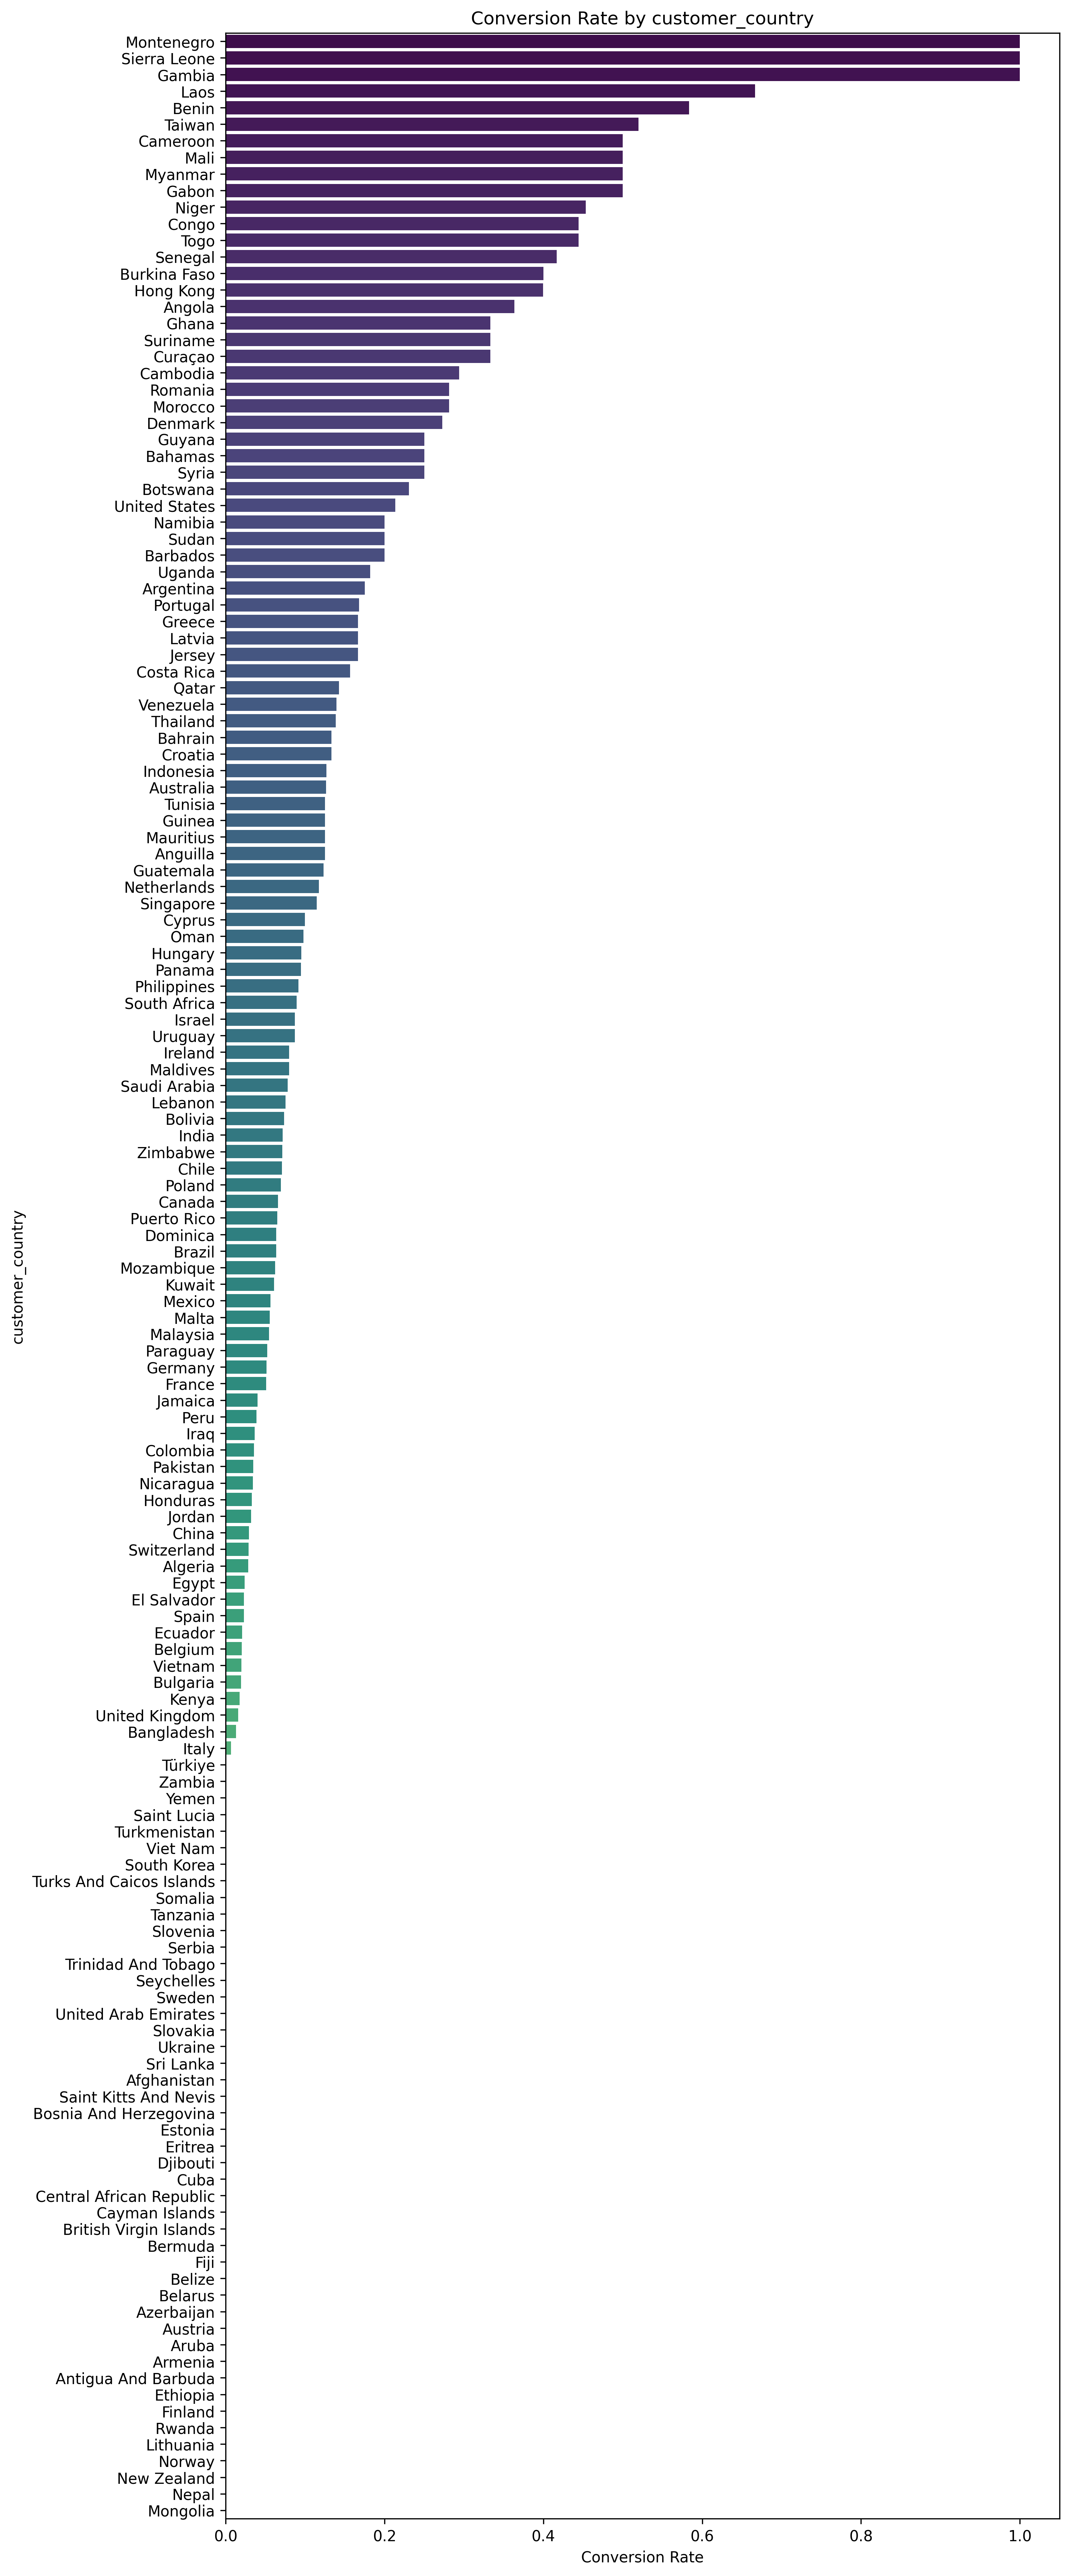

In [36]:
# 함수를 호출하여 그래프를 그립니다. 상위 20개의 카테고리만 표시합니다.
plot_conversion_rate_by_column(df_train, 'customer_country', top_n=150)

# 함수를 호출하여 그래프를 그립니다. 상위 20개의 카테고리만 표시합니다.
plot_conversion_rate_by_column(df_train, 'customer_city', top_n=150)

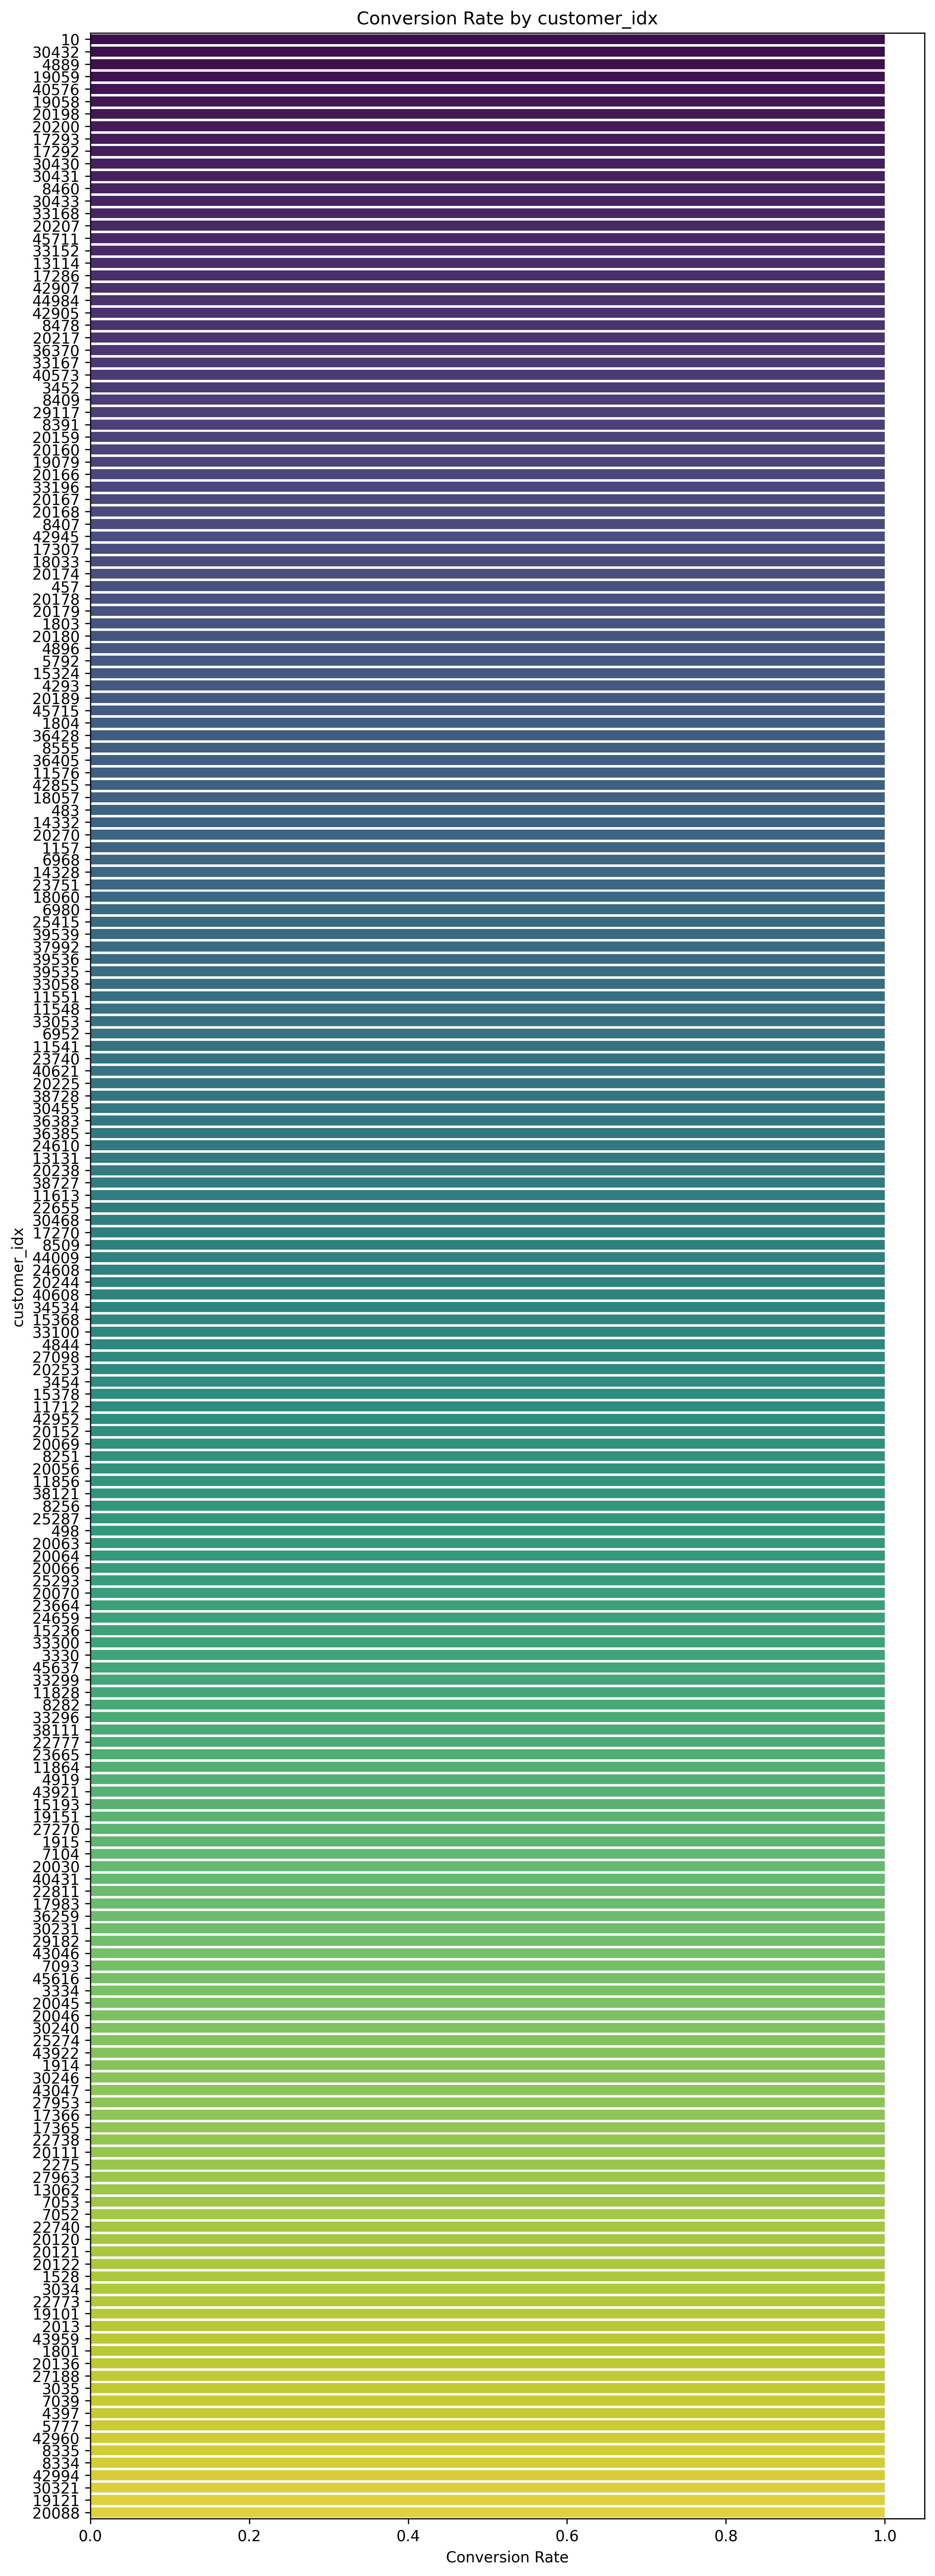

In [38]:
# 함수를 호출하여 그래프를 그립니다. 상위 20개의 카테고리만 표시합니다.
plot_conversion_rate_by_column(df_train, 'customer_idx', top_n=200)

In [13]:
# df_train 데이터 프레임을 복사하여 새로운 데이터 프레임을 생성합니다.
df_train_transformed = df_train.copy()
df_test_transformed = df_test.copy()

# 'object' 타입 변수 목록을 가져옵니다.
object_columns = df_train_transformed.select_dtypes(include=['object']).columns

# 각 object 타입 변수에 대한 변환 비율을 저장하는 딕셔너리를 생성합니다.
conversion_rate_dict = {}

for column in object_columns:
    # 각 object 타입 변수에 대해 is_converted의 평균값을 계산합니다.
    conversion_rate = df_train_transformed.groupby(column)['is_converted'].mean()
    
    # 계산된 평균값을 딕셔너리에 저장합니다.
    conversion_rate_dict[column] = conversion_rate
    
    # 새로운 컬럼 이름을 설정합니다.
    new_column_name = f"{column}_conversion_rate"
    
    # 원본 데이터 프레임에 새로운 컬럼을 추가합니다. map 함수를 사용하여 각 행의 값에 대응하는 비율을 적용합니다.
    df_train_transformed[new_column_name] = df_train_transformed[column].map(conversion_rate)
    df_test_transformed[new_column_name] = df_test_transformed[column].map(conversion_rate_dict[column])

    # 테스트 데이터에 없는 카테고리의 경우 0 또는 평균값으로 처리합니다.
    df_test_transformed[new_column_name].fillna(df_test_transformed[new_column_name].mean(), inplace=True)

# 불필요한 컬럼을 제거합니다.
df_train = df_train_transformed.select_dtypes(include=['float64', 'bool'])
df_test = df_test_transformed.select_dtypes(include=['float64', 'bool'])

# 이제 df_train과 df_test는 변환된 특성을 포함하고 있습니다.

In [14]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59299 entries, 0 to 59298
Data columns (total 8 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   is_converted                       59299 non-null  bool   
 1   customer_country_conversion_rate   37866 non-null  float64
 2   customer_idx_conversion_rate       59299 non-null  float64
 3   customer_type_conversion_rate      15338 non-null  float64
 4   customer_job_conversion_rate       40566 non-null  float64
 5   customer_position_conversion_rate  59299 non-null  float64
 6   enterprise_conversion_rate         59299 non-null  float64
 7   customer_city_conversion_rate      37866 non-null  float64
dtypes: bool(1), float64(7)
memory usage: 3.2 MB


In [33]:
df_test

,is_converted,customer_country_conversion_rate,customer_idx_conversion_rate,customer_type_conversion_rate,customer_job_conversion_rate,customer_position_conversion_rate,enterprise_conversion_rate,customer_city_conversion_rate
0,False,0.000000,0.008717,0.177928,0.096368,0.083791,0.055951,0.032852
1,False,0.015180,0.333333,0.177928,0.084290,0.083791,0.127161,0.032852
2,False,0.000000,0.223827,0.074851,0.168818,0.100523,0.127161,0.032852
3,False,0.058824,0.223827,0.155216,0.063571,0.083791,0.055951,0.032852
4,False,0.000000,0.223827,0.177928,0.089246,0.018672,0.055951,0.032852
...,...,...,...,...,...,...,...,...
5266,False,0.063609,0.000000,0.155216,0.063571,0.125144,0.055951,0.034226
5267,False,0.015180,0.008717,0.155216,0.084290,0.083791,0.055951,0.032852
5268,False,0.000000,0.223827,0.074851,0.090604,0.100523,0.055951,0.032852
5269,False,0.000000,0.223827,0.177928,0.084290,0.083791,0.127161,0.032852


1. 결측치 제거 했는데, F1 스코어가 엄청 내려감
2. OHE는 커널 날라감, 해쉬인코딩 	0.6999 나옴
3. rate값으로 변경해서 했는데, 점수 Public Score : 0.2674199623352166 나옴;

# Modeling

## Data 분리

from sklearn.model_selection import train_test_split

#X = df_train.drop('is_converted', axis=1)
#y = df_train['is_converted']

# 훈련 데이터와 검증 데이터를 분리합니다. (비율은 80:20)
x_train, x_val, y_train, y_val = train_test_split(
    df.drop("is_converted", axis=1),
    df["is_converted"],
    test_size=0.2,
    shuffle=True,
    random_state=400,
)

In [21]:
from pycaret.classification import *
clf = setup(data=df_train, 
            target='is_converted', 
            session_id=123, 
            use_gpu=True, 
            #normalize=True,  # 데이터 정규화
            #normalize_method='minmax',  # 정규화 방법
            #feature_selection=True,  # 특성 선택
            #remove_multicollinearity=True,  # 다중공선성 제거
            #categorical_imputation='lightgbm',  # 범주형 변수 결측치는 최빈값으로 대체
            #imputation_type='iterative',  # 반복적인(imputation) 방식 사용
            #categorical_features = col[:-1],
            verbose=True,
           )

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


,Description,Value
0,Session id,123
1,Target,is_converted
2,Target type,Binary
3,Original data shape,"(59299, 8)"
4,Transformed data shape,"(59299, 8)"
5,Transformed train set shape,"(41509, 8)"
6,Transformed test set shape,"(17790, 8)"
7,Numeric features,7
8,Rows with missing values,86.4%
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


In [22]:
# 모델 비교
best_model = compare_models(sort='F1', cross_validation=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.9954,0.9995,0.9661,0.9779,0.9719,0.9694,0.9695,0.8240
svm,SVM - Linear Kernel,0.9952,0.0000,0.9605,0.9800,0.9701,0.9675,0.9676,0.0300
ada,Ada Boost Classifier,0.9951,0.9996,0.9658,0.9747,0.9701,0.9675,0.9676,0.2930
lr,Logistic Regression,0.9952,0.9987,0.9517,0.9891,0.9700,0.9673,0.9676,0.0350
ridge,Ridge Classifier,0.9951,0.0000,0.9514,0.9884,0.9695,0.9669,0.9671,0.0190
lda,Linear Discriminant Analysis,0.9948,0.9914,0.9650,0.9717,0.9682,0.9654,0.9655,0.0720
lightgbm,Light Gradient Boosting Machine,0.9946,0.9994,0.9611,0.9730,0.9670,0.9640,0.9641,0.0930
knn,K Neighbors Classifier,0.9946,0.9923,0.9608,0.9730,0.9668,0.9639,0.9639,0.2460
et,Extra Trees Classifier,0.9946,0.9939,0.9585,0.9747,0.9664,0.9635,0.9635,0.2660
rf,Random Forest Classifier,0.9945,0.9976,0.9608,0.9713,0.9659,0.9629,0.9630,0.3040


In [23]:
# 하이퍼파라미터 튜닝
tuned_model = tune_model(best_model, optimize='F1')


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9949,0.9992,0.9528,0.9848,0.9685,0.9658,0.9659
1,0.9957,0.9996,0.9587,0.9878,0.9731,0.9707,0.9708
2,0.9945,0.9975,0.9410,0.9907,0.9652,0.9622,0.9626
3,0.9954,0.9998,0.9440,1.0000,0.9712,0.9687,0.9692
4,0.9959,0.9989,0.9588,0.9909,0.9746,0.9724,0.9725
5,0.9954,0.9985,0.9500,0.9938,0.9714,0.9689,0.9692
6,0.9935,0.9974,0.9294,0.9906,0.9590,0.9555,0.9561
7,0.9959,0.9985,0.9647,0.9850,0.9747,0.9725,0.9726
8,0.9937,0.9997,0.9441,0.9787,0.9611,0.9577,0.9579


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [ ]:
# 튜닝된 모델의 성능을 확인
evaluate_model(best_model)

In [31]:
# 검증 데이터에 대한 예측 및 F1 스코어 평가
y_val_pred = predict_model(best_model, data=x_val)

In [32]:
y_val_pred

,customer_country_conversion_rate,customer_idx_conversion_rate,customer_type_conversion_rate,customer_job_conversion_rate,customer_position_conversion_rate,enterprise_conversion_rate,customer_city_conversion_rate,prediction_label,prediction_score
9966,NaN,0.000000,NaN,0.139835,0.083791,0.127161,NaN,0,0.9999
18940,0.068433,0.000000,NaN,0.104221,0.100523,0.127161,0.044944,0,0.9999
33067,0.000000,0.000000,0.121345,0.000000,0.083791,0.055951,0.000000,0,0.9998
45290,0.045286,0.000000,NaN,0.089246,0.018672,0.055951,0.103448,0,0.9999
47453,NaN,0.000000,0.177928,NaN,0.083791,0.055951,NaN,0,0.9996
...,...,...,...,...,...,...,...,...,...
54631,NaN,0.000000,0.177928,NaN,0.083791,0.127161,NaN,0,0.9996
43005,NaN,0.008717,NaN,NaN,0.083791,0.055951,NaN,0,0.9959
28307,0.077119,0.000000,NaN,0.053174,0.089407,0.055951,0.000000,0,0.9999
2815,0.077119,0.000000,0.113886,0.081224,0.100523,0.127161,0.115385,0,0.9998


In [25]:
# functional API
evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…


Parameters
alpha	0.0001
average	False
class_weight	None
early_stopping	False
epsilon	0.1
eta0	0.001
fit_intercept	True
l1_ratio	0.15
learning_rate	optimal
loss	hinge
max_iter	1000
n_iter_no_change	5
n_jobs	-1
penalty	l2
power_t	0.5
random_state	123
shuffle	True
tol	0.001
validation_fraction	0.1
verbose	0
warm_start	False
Public Score : 0.19116135662898254

In [33]:
def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

In [34]:
get_clf_eval(y_val, y_val_pred['prediction_label'])


오차행렬:
 [[  908    39]
 [   17 10896]]

정확도: 0.9953
정밀도: 0.9816
재현율: 0.9588
F1: 0.9701


# Inference

In [ ]:
from pycaret.classification import *

# PyCaret setup
clf = setup(data=x_train, 
            target='is_converted',  # 목표 변수 지정
            session_id=123, 
            use_gpu=True, 
            remove_multicollinearity=True,  # 다중공선성 제거
            verbose=True,
           )

# 모델 비교
best_model = compare_models(sort='F1', cross_validation=True)

# 하이퍼파라미터 튜닝
tuned_model = tune_model(best_model, optimize='F1')

# 튜닝된 모델의 성능을 검증 데이터셋에서 확인
evaluate_model(tuned_model)

In [26]:
# 예측에 필요한 데이터 분리
x_test = df_test.drop(["is_converted"], axis=1)

In [27]:
# PyCaret 모델을 사용하여 테스트 데이터에 대한 예측 수행
test_predictions = predict_model(best_model, data=x_test)

In [28]:
# 예측 결과에서 라벨 추출 (PyCaret에서는 예측 라벨이 'Label' 컬럼에 저장됩니다)
test_pred = test_predictions['prediction_label'].apply(lambda x: True if x == 1 else False)

In [29]:
# True로 예측된 개수
num_true_predictions = sum(test_pred == 1)
print(f"Number of True predictions: {num_true_predictions}")

Number of True predictions: 362


In [30]:
# 제출 데이터 로드 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")

In [31]:
# 예측 결과를 'is_converted' 컬럼에 저장
df_sub["is_converted"] = test_pred

In [32]:
# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)
# 파일 저장 완료 메시지 출력
print("Submission file has been saved.")

Submission file has been saved.
